<h1>Generative Adversarial Networks - Image generation - Fashion Mnist Dataset</h1>



In [27]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [28]:
ds = tfds.load('fashion_mnist', split='train')


In [29]:
# ds = ds.take(20000)
# len(ds)

In [30]:
ds.as_numpy_iterator().next().keys(), ds.as_numpy_iterator().next()['label']

(dict_keys(['image', 'label']), np.int64(2))

In [31]:
for i in ds.take(1):
    print(i['image'].shape)

(28, 28, 1)


In [32]:
dataiterator = ds.as_numpy_iterator()

<h3>Data Visualization</h3>

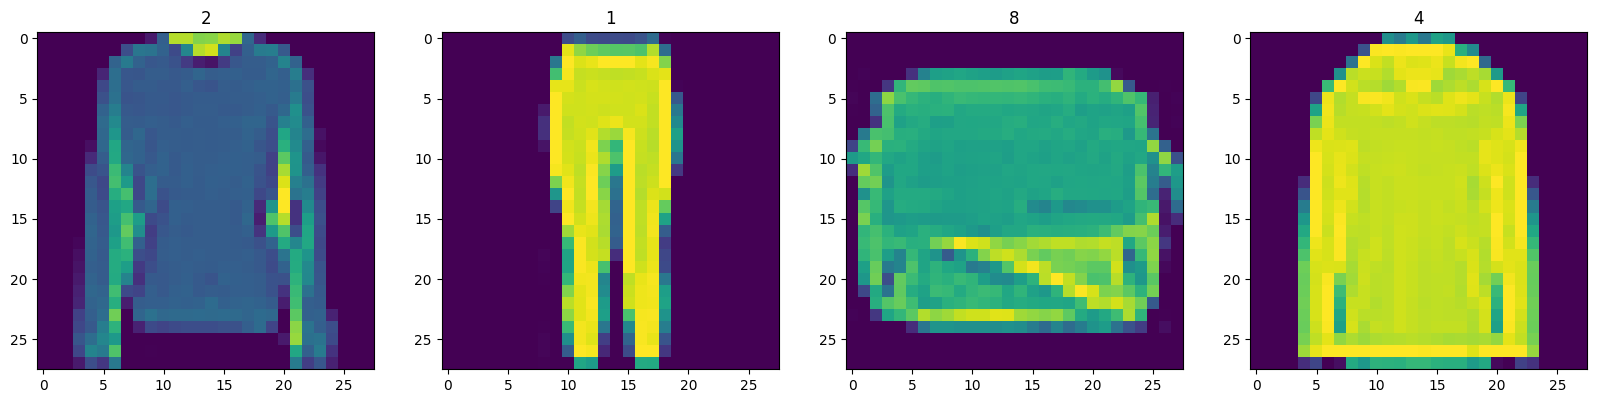

In [33]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for i in range(4):
    batch = dataiterator.next()
    ax[i].imshow(batch['image'])
    ax[i].title.set_text(batch['label'])

In [34]:
def scale_images(data):
    image = data['image']
    return image/255

In [35]:
BATCH_SIZE = 128
ds = (ds
      .map(scale_images)
      .cache()
      .shuffle(60000)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
      )

In [36]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

<h2>Build Neural Network</h2>

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Dense, Flatten, LeakyReLU, Reshape, Dropout, UpSampling2D

<h3>Build Generator</h3>

In [53]:
def build_generator():
    model = Sequential([


        Input(shape=(128,)),
        Dense(7*7*128),
        LeakyReLU(0.2),
        Reshape((7,7,128)),

        UpSampling2D(),   # double the size by 2
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),

        UpSampling2D(),    
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),

        Conv2D(128, 4, padding='same'),
        LeakyReLU(0.2),

        Conv2D(128, 4, padding='same'),
        LeakyReLU(0.2),

        Conv2D(1, 4, padding='same', activation='sigmoid')


    ])
    return model

In [54]:
generator = build_generator()
generator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


((4, 28, 28, 1), <matplotlib.image.AxesImage at 0x28850b9b2c0>)

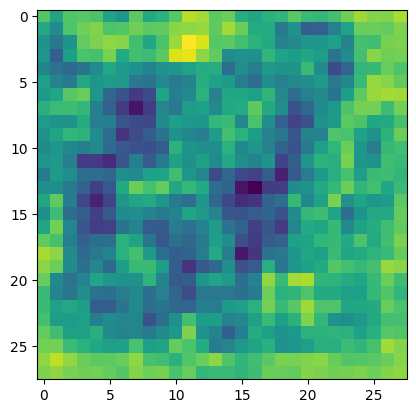

In [40]:
img = generator.predict(np.random.rand(4, 128, 1))  # generate 4 images
img.shape, plt.imshow(img[0])

<h3>Build Discriminator</h3>

In [41]:
def build_discriminator():
    model = Sequential([
        Input(shape=(28,28,1)),

        # First Conv Block
        Conv2D(32, 5),
        LeakyReLU(0.2),
        Dropout(0.4),

        # Second Conv Block
        Conv2D(32*2, 5),
        LeakyReLU(0.2),
        Dropout(0.4),
        
        # Third Conv Block
        Conv2D(32*4, 5),
        LeakyReLU(0.2),
        Dropout(0.4),
        
        # Fourth Conv Block
        Conv2D(32*6, 5),
        LeakyReLU(0.2),
        Dropout(0.4),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    
    return model

In [42]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 192)    │       614,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 12, 12, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12, 12, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        27,649 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 899,265 (3.43 MB)

 Trainable params: 899,265 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
discriminator.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


array([[0.50083566],
       [0.50074786],
       [0.50068915],
       [0.5006865 ]], dtype=float32)

<h2>Custom Training Loop</h2>

In [44]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [45]:
# generator optimizer; higher learning rate for generator
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [46]:
from tensorflow.keras.models import Model

In [47]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss


    def train_step(self, batch):

        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply Backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 

        # Apply Backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": total_g_loss}
    
    

In [48]:
fashgan = FashionGAN(generator, discriminator)
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [49]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [50]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

<h2>Train the model</h2>

In [51]:
# Recommend 2000 epochs
# hist = fashgan.fit(ds, epochs=10, callbacks=[ModelMonitor()])

<h3>Test the generator</h3>

In [55]:
generator.load_weights('generatormodel.h5')

ValueError: Shape mismatch in layer #0 (named dense_4)for weight sequential_4/dense_4/kernel. Weight expects shape (128, 6272). Received saved weight with shape (1, 256)

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])